In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import seaborn as sns
import json
import matplotlib.pyplot as plt
from gensim import corpora, models
import pickle
import nltk

In [2]:
def load_json_to_df(datapass):
    data = [] 
    with open(datapass) as data_file: 
        for f in data_file:
            data.append(json.loads(f))
    df = pd.DataFrame(data)
    return df

In [3]:
business = load_json_to_df("../../../dataset/business.json")

In [4]:
review = load_json_to_df("../../../dataset/review.json")

In [5]:
by_city = business.groupby('city').size().reset_index(name='counts')

In [6]:
by_city.sort_values('counts',ascending=False)

,city,counts
396,Las Vegas,24768
656,Phoenix,15656
909,Toronto,15483
136,Charlotte,7557
806,Scottsdale,7510
675,Pittsburgh,5688
526,Montréal,5175
491,Mesa,5146
317,Henderson,4130
900,Tempe,3949


## Overview:
Train the matrix of business subscores by minimizing a loss function for each restaurant, defined by sum((rec - rating)^2), where rec is (rating subscores dot user preference).

We obtain user preference by running an LDA on all the text reviews, that is, we are setting the preference column as a constant in the loss function. 

The weight for each topic is calculated by normalizing the sum of the probabilty that each word of one user's texts occurs in the topics generated by LDA on all reviews.

In [7]:
review.head(5)

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,uYHaNptLzDLoV_JZ_MuzUA,0,2016-07-12,0,VfBHSwC5Vz_pbFluy07i9Q,5,My girlfriend and I stayed here for 3 nights a...,0,cjpdDjZyprfyDG3RlkVG3w
1,uYHaNptLzDLoV_JZ_MuzUA,0,2016-10-02,0,3zRpneRKDsOPq92tq7ybAA,3,If you need an inexpensive place to stay for a...,0,bjTcT8Ty4cJZhEOEo01FGA
2,uYHaNptLzDLoV_JZ_MuzUA,0,2015-09-17,0,ne5WhI1jUFOcRn-b-gAzHA,3,Mittlerweile gibt es in Edinburgh zwei Ableger...,0,AXgRULmWcME7J6Ix3I--ww
3,uYHaNptLzDLoV_JZ_MuzUA,0,2016-08-21,0,llmdwOgDReucVoWEry61Lw,4,Location is everything and this hotel has it! ...,0,oU2SSOmsp_A8JYI7Z2JJ5w
4,uYHaNptLzDLoV_JZ_MuzUA,0,2013-11-20,0,DuffS87NaSMDmIfluvT83g,5,gute lage im stadtzentrum. shoppingmeile und s...,0,0xtbPEna2Kei11vsU-U2Mw


## Preprocessing:
0. Extract all the restaurant reviews.
1. tokenize
2. stop words
3. stemmize
4. get only nouns and adjs

In [8]:
is_rest = []
for i in business['categories']:
    
    if 'Restaurants' in i or 'Food' in i:
        is_rest.append(True)
    else:
        is_rest.append(False)
is_burger = []
for i in business['categories']:
    
    if 'Burgers' in i:
        is_burger.append(True)
    else:
        is_burger.append(False)

restaurants = business.loc[is_burger]
restaurants.shape

(4236, 15)

In [9]:
LV_restaurant = restaurants.loc[restaurants['city']=='Las Vegas']

In [10]:
LV_restaurant.shape

(505, 15)

In [11]:
rest_id = LV_restaurant['business_id']
rest_review = review.loc[review['business_id'].isin(rest_id)]
rest_review.shape

(77112, 9)

In [12]:
#rest_review.to_csv("rest_review.csv", index=False)

In [13]:
#groupby_user = rest_review.groupby('user_id').size().reset_index(name='counts')

In [14]:
#groupby_user.sort_values('counts',ascending=False)

In [15]:
#preprocess
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

from nltk.corpus import stopwords
en_stop = stopwords.words('english')

from nltk.stem.porter import PorterStemmer
p_stemmer = PorterStemmer()

def preprocess(text):
    raw = text.lower()
    tokens = tokenizer.tokenize(raw)
    
    pospeech=[]
    tag = nltk.pos_tag(tokens)
    for j in tag:
        if j[1] == 'NN' or j[1] == 'JJ':
            pospeech.append(j[0])
    # remove stop words from tokens
    stopped_tokens = [i for i in pospeech if not i in en_stop]
    
    # stem tokens
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    
    # add tokens to list
    return stemmed_tokens



## Generating LDA 
For demo purpose, running LDA on only one user.

In [16]:
NUM_TOPICS = 120
from gensim import corpora, models


def getlda(df):
    texts = []
    for i in df['text']:
        texts.append(preprocess(i))
    # turn our tokenized documents into a id <-> term dictionary
    dictionary = corpora.Dictionary(texts)
    # convert tokenized documents into a document-term matrix
    corpus = [dictionary.doc2bow(text) for text in texts]
    # generate LDA model
    ldamodel = models.ldamodel.LdaModel(corpus, num_topics=NUM_TOPICS, id2word = dictionary, passes=20, eval_every=None)
    return ldamodel

## Calculate preference maxtrix
Add up the probabity that each word in the corpus in each topic, then add up for each topic and normalize.

In [17]:
def getprefer(userid, ldamodel, df):
    user_reviews = df.loc[df['user_id'] == userid]
    l = np.zeros(NUM_TOPICS)
    texts = []
    for t in user_reviews['text']:
        texts.append(preprocess(t))
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    for i in ldamodel.get_document_topics(corpus):
        for topic in i:
            l[topic[0]] += topic[1]
    topic_likelihood = []
    sum_l = sum(l)
    if sum_l > 0:
        for i in l:
            topic_likelihood.append(i/sum(l))
    else:
        topic_likelihood = np.full(NUM_TOPICS, 1/NUM_TOPICS)
    return topic_likelihood

## Minimize loss function
<img src="formula.png">
Since we setting the topics for each user as constant, the corpus likelihood here is a constant so we only need to deal with rating error.

We used Sequential Least SQuares Programming (SLSQP) to minize the function.

Intial guess was randomized between 1.0 and 5.0

Might need to explore bias and hyperparameters in the future.

In [53]:
from scipy.optimize import minimize
def min_loss(raw_prefer, actual_rating):
    
    dim = NUM_TOPICS
    prefer = []
    for i in raw_prefer:
        prefer.append(np.asarray(i, dtype=np.float32))
    prefer = np.asarray(prefer)
    bound = []
    for i in range(0,dim):
        bound.append((1.0,5.0))
    bnds = tuple(bound)


    def f(x,prefer,actual_rating):

        return sum(abs(np.dot(x,np.transpose(prefer)) - actual_rating))
    initial_guess = [np.random.uniform(1.0,5.0,dim)]
    #initial_guess = np.full(5,2.5)

    result = minimize(f, initial_guess, args=(prefer,actual_rating), method='SLSQP', bounds=bnds, options={'disp': False, 'iprint': 1, 'eps': 1.4901161193847656e-08, 'maxiter': 1000, 'ftol': 1e-06})

    if result.success:
        fitted_params = result.x
        print ("param")
        print(fitted_params)
        print ("fun")
        print(result.fun)
        print(result.nit)
        return result
    else:
        return -1

## Combine everything
For each restaurant, run the algorithm to get the subscores, which will take a couple days on MacBook ~~Pro~~.

In [19]:
def add_prefer_to_df(df, lda, groupbyusers):
    d = {}
    new_df = df
    for u in groupbyusers['user_id']:
        d[u] = getprefer(u,lda,new_df)
    new_df['preference'] = new_df.apply(lambda x: d[x['user_id']],axis=1)
    return new_df

In [54]:
def train_rest_subscore(bizid, df):
    biz = df.loc[df['business_id'] == bizid]
    rating = biz['stars']
    preference = biz['preference']
    result = min_loss(preference.values, rating.values)
    return result.x

In [81]:
def getsubscore(df, groupbybiz):
    d = {}
    counter = 0
    for u in groupbybiz['business_id']:
        counter +=1
        print (counter)
        d[u] = train_rest_subscore(u, df)
    #df['subscore'] = df.apply(lambda x: d[x['business_id']],axis=1)
    return d

In [82]:
from sklearn.model_selection import train_test_split
def split(groupbybiz, df):
    trains = []
    tests = []
    for i in groupbybiz['business_id']:
        biz = df.loc[df['business_id'] == bizid]
        train, test = train_test_split(biz, test_size=0.30, random_state=42)
        trains.append(train)
        tests.append(test)
    train_df = pd.concat(trains)
    test_df = pd.concat(tests)
    return train

In [35]:
sample = rest_review.sample(5000)

In [36]:
sample_lda = getlda(sample)

In [37]:
groupby_user_sample = sample.groupby('user_id').size().reset_index(name='counts')

In [38]:
perfer_added_to_sample = add_prefer_to_df(sample, sample_lda, groupby_user_sample)

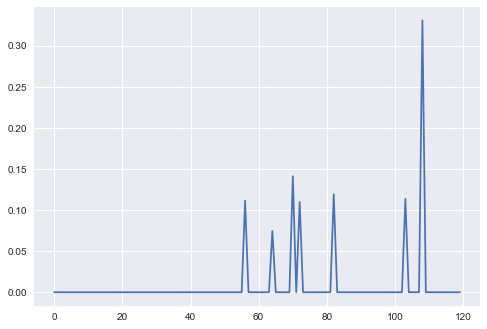

In [39]:
prefer_added_to_sample = perfer_added_to_sample
plt.plot(prefer_added_to_sample['preference'].iloc[1])

In [40]:
l = list(np.empty(NUM_TOPICS))
for i in prefer_added_to_sample['preference']:
    for p in range(len(i)):
        l[p] += i[p]
print (l)

[0.61612265093349217, 81.233864330830684, 0.71539606394009814, 0.44010646229444983, 2.6541742472046725, 22.84485110883049, 15.353799247883332, 0.0083333333333333332, 0.61471008845231767, 0.34166666666666667, 40.767877811658643, 1.899248228213458, 0.29402093368470955, 1.0618366027241382, 6.166597463866923, 40.746073236138344, 0.58528414167951492, 117.03626424702912, 0.0083333333333333332, 0.0083333333333333332, 0.0083333333333333332, 335.07388259512527, 4.0317163617630349, 3.9591363955207823, 0.25452363230703651, 32.495323075926194, 48.504091319610069, 3.6220873645020575, 1.9557868238920491, 0.0083333333333333332, 5.3325129148347878, 28.064115984176585, 0.0083333333333333332, 2.5330713016773108, 0.7962718355287236, 39.347574084556747, 1.1625093182295909, 0.045734130760438321, 0.0083333333333333332, 0.52477456200985306, 1.5701552584472462, 0.0083333333333333332, 21.494208041199158, 0.0083333333333333332, 0.85945662708540171, 0.0083333333333333332, 0.0083333333333333332, 123.7415191294345

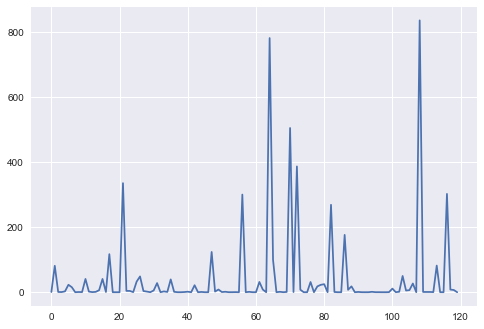

In [41]:
plt.plot(l)

In [42]:
groupby_rest_sample = sample.groupby('business_id').size().reset_index(name='counts')

In [59]:
subscores = getsubscore(prefer_added_to_sample, groupby_rest_sample)

1
param
[ 3.08738447  1.          3.66433789  1.02363986  3.19320859  1.          1.
  2.43115026  4.21688459  3.65783733  1.          3.82027362  4.13989739
  2.70675088  2.79239523  5.          1.48713874  1.          1.46087029
  4.81313263  3.86724498  4.67413054  2.84468816  4.40079002  1.02653841
  1.          1.          4.54823179  2.97604396  3.81082071  2.20764016
  4.38487354  1.08545694  3.52309656  2.90021283  2.21769085  1.68052837
  3.81981463  1.05969662  1.41984898  4.76556982  4.06673952  1.
  2.80927896  3.20541741  2.05795227  1.77736541  1.          3.6537732   1.
  4.35550048  1.82003538  1.67304776  4.68530904  2.40572742  3.20181204
  5.          2.94115471  3.51634244  1.68379305  3.82199508  1.          1.
  1.6581984   5.          5.          1.91197165  4.40819684  2.47851833
  4.32509673  3.72425313  4.78355548  1.          1.          4.17721061
  1.86951902  1.00000274  2.23786095  4.17365724  1.          1.
  2.01514646  4.0561352   4.31452334  2.5745939

param
[ 1.33132445  1.          1.16278062  4.80462134  4.08104046  5.
  4.63804951  2.30326376  3.97292775  1.0080583   5.          4.64491159
  4.7966635   2.79876223  3.10553993  5.          3.11710421  2.97449006
  1.07964904  1.84221315  3.6440025   1.          4.94018431  3.74699431
  3.60435581  3.11486152  5.          4.98016961  3.17335137  4.30947051
  1.9910096   3.29087948  1.4018067   4.8534704   2.0960901   5.
  3.26716696  2.84027526  2.66354171  1.03431672  4.25059412  3.20370717
  5.          4.54540642  1.97653286  4.27310291  2.9761021   5.
  1.98908179  5.          1.49715858  2.62801015  2.12912117  4.72297643
  1.91662206  4.99998624  5.          1.73849554  4.87408797  2.02974104
  1.12794467  2.58514174  2.09933287  4.9391353   4.99999916  1.83841813
  1.93090781  2.44071196  2.24519871  1.7173139   5.          3.20921585
  5.          2.1772745   1.13767609  4.74678908  3.94489742  1.13182133
  1.          5.          5.          4.60190976  5.          3.39027

param
[ 1.93286554  5.          4.15795478  2.20151266  3.21958296  5.          5.
  4.75554572  5.          2.35938636  5.          4.66583037  3.63730219
  4.9998337   5.          1.          4.9741197   5.          2.61878572
  3.02720007  4.2326226   5.          4.08140855  1.7551677   4.02505794
  5.          5.          4.02341006  5.          4.42823939  1.98996379
  1.81596874  3.05932383  3.50009486  5.          1.          1.72754569
  1.50149868  1.38113838  3.88163637  5.          1.39228864  1.
  1.33750826  2.73850298  2.7103296   1.70356816  4.83475128  4.99794568
  5.          3.67411619  2.40137246  4.55098592  3.22844665  4.97588253
  1.90997697  1.          3.54149368  2.7593676   1.10226808  4.09368995
  5.          1.          2.87627909  5.          5.          4.9202435
  3.88895319  1.77852194  4.9130051   1.          5.          1.          1.
  2.72350174  1.32122407  5.          1.10230327  2.66266703  1.          1.
  3.23153707  5.          4.23969617  2.36

param
[ 1.32448679  5.          4.50528188  1.5523473   2.90707807  3.74802828
  2.33691006  1.19111483  2.99347068  2.62630741  5.          3.22253865
  1.35472488  2.48158359  4.33016865  5.          3.39916002  5.
  3.06289362  4.82958596  4.93556668  5.          2.10907761  1.39011722
  1.85331956  5.          2.45067094  4.69165954  4.04493668  2.26526782
  1.00000008  3.4037951   4.42046217  1.38045017  3.23705063  5.
  4.53499968  3.98033427  4.51128764  4.55418183  2.43395974  4.09250488
  3.9486751   3.9333768   2.47755415  2.37974666  3.3968723   4.96805483
  2.3618294   4.937501    3.73160196  4.55460882  1.24261508  4.44749379
  4.66160104  3.17440601  4.80695724  3.14868764  1.16503593  4.84546406
  2.8255944   5.          3.40303139  1.74917686  5.          5.
  2.80635245  1.23021362  1.81752092  4.69384981  5.          4.44186987
  1.00000038  2.96934219  1.6082409   2.64005688  2.62301806  1.694155
  2.23365684  5.          4.84174062  1.14647321  5.          3.3815502

param
[ 4.99555155  5.          1.          3.01620222  2.46198511  5.          1.
  3.6749894   4.86891465  2.77022652  5.          1.          3.52113576
  3.67666299  5.          5.          3.71426638  5.          4.35218293
  2.62621043  1.26944855  5.          1.          3.12205445  1.20395449
  1.          5.          1.          5.          2.13204143  1.
  3.68576018  4.28848236  1.          5.          5.          2.8567424
  2.61662797  2.86495241  2.6731779   1.          2.78088403  5.
  1.69433658  1.          4.88861966  4.25886517  5.          1.          5.
  4.35968905  5.          3.34710343  3.92138812  2.20848663  4.28417242
  1.          4.00663106  4.78078467  2.43130509  2.32621904  5.
  1.95849268  1.09568593  1.42357829  5.          1.07675198  5.          4.8271743
  2.51415727  5.          5.          2.05692403  5.          4.56807003
  3.39321035  2.0351582   4.00653204  5.          5.          5.
  1.91060126  1.          5.          3.79626017  2.2958752

param
[ 2.77954127  4.99999948  1.07379057  3.84607135  2.79986452  1.92720096
  4.14383893  3.34382394  4.08566957  3.08174088  5.          3.98535697
  3.75139353  3.39956589  4.73974708  1.          2.93222149  5.          1.4668556
  4.63538496  2.00079997  1.73240407  2.71651661  2.6484768   2.50877151
  5.          1.59165477  2.24748237  1.32778189  2.65734245  3.91724285
  1.29944005  3.09999637  1.63488084  1.7689152   5.          3.28347361
  4.78506176  1.96568764  4.70197272  3.35284457  2.95976871  1.
  1.93263118  4.08506027  2.65007487  2.55010778  5.          1.29646362
  2.20872496  1.30906903  4.58173974  2.1684401   1.00772238  4.7394181
  2.07796338  5.          3.69964291  2.82633739  4.21419644  3.05688121
  4.99995808  5.          3.94986955  5.          5.          3.70865895
  4.04342484  1.55124945  4.62899502  5.          4.57528769  5.
  4.99988111  3.59527835  1.97229717  1.          2.02609068  5.          5.
  4.99999932  4.88458176  5.          4.3573634

param
[ 2.86898944  1.          4.2374643   1.78900673  3.94329556  1.98611705
  2.40644374  3.7205365   3.73375667  2.67632523  1.06094183  4.18888635
  3.85777363  2.00745756  3.50248696  2.48764011  2.02032521  4.18603372
  4.12240742  1.26934551  1.78731843  1.97256695  4.13903145  4.34037062
  2.00192125  1.13504396  2.87359565  2.97023649  2.41403015  1.648908
  2.56590827  1.0302424   1.08704931  2.43614929  2.76851364  3.6333803
  2.20008337  3.11139287  1.87374823  3.67596757  3.19074498  3.73759747
  3.55293399  4.44538936  4.93750159  2.46514989  2.05304302  4.35969123
  4.03714217  1.92062611  2.50563651  3.76361403  3.72391309  3.02604227
  3.4800694   2.45213182  1.          3.0459699   1.58385444  1.56105562
  2.67254857  4.85821587  3.8830075   4.95765363  5.          1.59140218
  1.80565433  1.430195    2.75526552  2.32827334  5.          3.17534094
  1.          3.56500488  1.26997551  2.59376699  3.69649642  3.29197756
  3.57826995  1.634708    2.31981296  1.96767651

param
[ 1.          1.          4.76990199  5.          5.          1.          5.
  4.01628225  2.63409269  3.06119733  1.          1.          1.          5.
  1.          1.          1.55524106  1.          3.12983797  4.96513644
  1.18677511  5.          3.26243431  1.          1.          5.          1.
  5.          1.          3.58839687  5.          1.          3.10029877
  1.          1.          1.          5.          1.07834076  2.9721301
  1.47020027  5.          2.25281932  1.          1.37643018  1.          1.5271727
  1.32481215  1.          2.97991415  1.          2.91209335  5.
  3.21350939  1.4549762   4.66863758  3.86757745  5.          4.76664817
  2.99106431  2.11895241  4.31352391  5.          1.          2.95259409
  5.          1.          2.09708072  5.          4.63876292  3.83489853
  5.          5.          5.          5.          4.6742186   1.7082772   5.
  3.16313145  5.          1.          1.          1.85447888  5.          1.
  1.24990805  2.6458933

param
[ 3.57578505  5.          3.32943593  1.01740372  1.89043111  1.00000001
  5.          1.86066236  2.72344558  4.03206361  1.          1.15327346
  4.719585    2.96851155  4.2859039   1.          2.5247728   1.
  2.26103494  2.56196094  3.74445529  5.          3.41629872  4.25431532
  2.06039608  1.          5.          4.55051467  4.95253757  4.06913907
  4.39066539  2.48867631  3.77279147  2.93303254  4.77941243  1.
  1.01720265  4.36888419  1.87369069  4.28406588  1.18382281  3.65411667
  1.          4.31282579  2.54345372  4.75879236  1.38831345  1.
  3.74578627  1.          1.07542853  3.76644595  3.06075374  4.413999
  3.57457878  2.63021234  2.98347423  4.96486493  1.44585908  1.78312555
  1.97456125  1.          1.42316027  2.61945924  2.06239401  1.
  1.12876436  2.6814222   2.22584011  2.98995283  4.99999985  3.55415706
  5.          1.35199047  4.49699745  3.12367813  1.          2.23200776
  5.          1.          1.          1.49259398  5.          3.78071584
  3.10

param
[ 2.38680791  1.          3.56771856  1.40653262  1.          2.63243739
  1.80793678  2.0886738   3.18475581  2.45138731  5.          1.47485279
  2.45555114  3.75680065  2.7794141   1.          1.54150197  5.
  2.49604729  4.5670054   1.1052953   1.          3.06882683  4.0448437
  2.75813062  1.          5.          4.64080091  2.9541284   1.52565737
  2.66258732  3.9790976   1.14303173  3.51284195  3.9820481   1.44926814
  1.8921788   2.82976112  4.39207295  2.59308932  4.51366069  4.66009425
  1.          3.43938212  2.272486    1.09838393  2.87960384  1.
  3.52140849  1.98046714  1.7385414   3.32871908  2.8717585   4.92095605
  1.70412873  2.60527682  1.          2.13471396  3.73571855  4.33626607
  4.51489557  5.          4.39905634  1.09986629  1.          5.
  1.93425804  1.02536588  1.71114293  3.94625889  1.          1.73167429
  1.          1.          1.01345708  3.62657897  3.61673598  1.28618694
  3.06825388  5.          1.          1.34812253  1.          2.068460

param
[ 1.15812187  1.          1.          1.          1.          1.          5.
  3.84615034  5.          3.70323988  5.          1.56930499  2.58957267
  1.          1.03451858  5.          5.          2.29547318  2.56558
  4.91828952  2.03695792  5.          3.0141901   1.          2.46473743
  5.          1.          5.          4.99999066  2.84962084  1.1411128
  3.7587547   1.43678456  2.14801938  1.72745147  5.          5.
  3.11637297  4.65339198  5.          3.54359851  1.24384996  1.0074085
  3.23856873  1.          1.89781671  1.35983416  5.          5.          5.
  3.34253926  4.12091432  1.98661141  3.37698689  1.88042109  4.37787574
  1.          3.46965345  3.67825461  4.29439844  2.5428091   5.          5.
  2.18230639  5.          5.          1.41789398  5.          1.          5.
  2.20945514  5.          2.56902434  1.80450258  4.60978329  4.43095849
  1.          3.57853226  5.          5.          5.          1.1933417   1.
  4.82677195  3.99467357  2.61283187  

param
[ 4.22485999  4.40124404  3.45534701  1.27392214  3.14436788  5.
  2.73273041  1.68644387  1.76780234  4.19398075  5.          3.52617112
  2.66802044  4.38630711  1.91969023  5.          2.84594361  1.
  3.34024592  3.06745497  4.7596171   1.          4.07247469  4.42017352
  2.20650391  1.          5.          1.87602538  3.74289677  2.14966928
  2.86084669  1.          4.94855307  2.23952923  4.6286357   1.
  2.98507353  4.99942262  4.90851917  4.95156714  1.74950456  3.25952813
  5.          1.57163484  2.64995077  1.68656251  2.99218412  5.
  2.27243034  5.          3.0263071   4.90600597  2.07007786  3.18243831
  4.6826633   4.76271166  3.55792623  1.00798772  1.72574646  2.90632192
  3.97179549  1.          4.14962966  1.06321909  4.48975748  4.95003711
  2.48979334  2.92293228  1.45178909  1.70335603  1.          4.58746939
  5.          3.66116382  3.09548977  3.18953567  5.          1.80417497
  1.          1.          1.          4.76830503  4.02057799  4.53706022
  4.

param
[ 4.81412786  3.00515334  2.00181145  3.71660573  3.61648241  2.82454286
  3.1181789   4.68770124  1.19286483  4.54607341  4.08253612  1.27271196
  1.36226729  4.23572263  1.11282703  2.46596305  4.26091126  1.99466923
  4.58099629  2.23941963  1.53465646  3.21774403  1.71125666  1.97200869
  3.06990545  1.07740131  4.46388464  3.5570518   2.73678315  4.99056603
  4.14121753  3.18467393  2.61178372  3.10401262  2.02961988  4.75099981
  3.10914862  4.84872259  4.15516342  4.86835678  2.42912144  2.79107197
  1.24162699  4.04460279  3.2611349   1.1037931   1.47051007  3.06302273
  4.91676291  1.78385574  2.2145016   3.32633864  3.17817242  2.49355074
  1.59169165  2.5839232   3.54765262  4.12293593  2.58179534  2.91205007
  3.16051508  3.89782745  2.3942155   1.61783939  1.00000001  3.9901151
  3.77944762  2.37823123  4.41308906  2.84667881  2.84909069  2.27006859
  3.3655968   1.42953311  2.69312741  4.96755851  4.60114045  4.35202191
  3.16300013  4.03121681  1.40389275  2.512076

param
[ 1.46243761  5.          2.99759218  3.68081412  4.4684171   3.20243419
  4.53077164  3.32032721  4.63398273  1.60677488  1.          2.76179685
  1.39301241  4.62930595  2.43515216  1.          3.77629712  1.          2.770789
  1.30484542  1.29859123  1.          1.2468507   1.8308338   4.90453893
  1.          3.02137317  1.29719716  2.57764523  3.82275335  1.44055879
  4.5055806   1.8566222   2.37952408  2.63209075  1.          1.64012562
  1.20230895  2.41773434  2.74518896  2.79815889  1.25480862  1.
  2.93768857  4.7147527   4.96210526  3.24201323  1.          1.31462893
  4.92161444  4.37809473  4.41903966  3.8359365   2.7481331   2.26591892
  1.25533311  1.          1.65950944  3.11795081  2.49608078  4.80663491
  1.          3.4981735   4.52771542  1.          1.          2.5442222
  3.64596087  1.56154071  1.54181758  1.          4.63871693  1.
  1.63733794  1.95373777  2.0050061   3.58382328  2.54229458  3.44094338
  1.          2.8466792   2.64248265  1.          1.

param
[ 1.          5.          4.0211597   3.47220502  1.          5.          1.
  2.51443055  1.27803763  1.22399651  1.          1.          1.
  2.68294741  1.          5.          4.1238132   5.          4.49466605
  1.96292782  1.47908079  5.          1.20050564  1.          1.          1.
  5.          1.          1.          3.87679145  1.          1.
  2.37742386  1.          1.          5.          1.          2.4176372
  1.24057158  1.34343359  1.          1.31893219  5.          3.01504088
  1.          1.97626791  2.13063141  2.01379522  1.          5.
  4.93609065  1.          4.82673893  4.25127542  2.00637527  2.36101332
  1.          3.97799831  1.          4.03078752  4.47878899  1.          1.
  4.59953047  5.          5.          1.12482855  1.43462653  3.45903733
  3.82700262  5.          2.53350756  4.96411992  1.          4.03908512
  2.02735956  1.37023589  3.81111763  1.          5.          5.
  3.09180233  1.05015285  1.          4.80017415  4.10902267  1.06

param
[ 2.75642747  1.30555431  1.43019907  1.03158698  4.56417161  1.79231776
  4.33989862  4.48447485  3.54743084  4.4089408   3.5392095   3.54320037
  2.16377649  4.91015712  2.04415635  1.13784618  4.66612965  3.02983609
  1.96460668  1.32141014  2.36146897  1.          3.94716687  2.71500423
  3.71799205  4.47784835  2.69154882  1.26319008  3.2378784   1.78790951
  3.30080824  4.94407622  4.17109673  2.37110411  4.46878405  2.17812892
  4.01065134  2.42032661  4.05899109  2.6206769   4.23994108  1.74514872
  2.61865254  3.32653816  4.53625318  1.64580272  3.6455245   2.67432223
  4.17239996  2.80768635  4.09188743  1.39759499  1.60333282  2.98199055
  3.91556477  1.02206268  2.87897416  2.44715236  4.98713628  2.66759568
  2.98642184  3.71766802  4.15272416  4.84670449  1.          1.
  4.96762887  3.70307778  2.5875693   1.42942624  1.          2.15901207
  1.          3.77511528  2.20306284  1.11519235  3.29617004  3.48597606
  3.73622849  2.14766059  1.21269611  3.42620552  1. 

105
param
[ 1.02601703  1.32549713  1.74314837  4.16438996  1.03181261  1.
  1.47420065  2.25655851  4.87410754  4.61450799  2.52080223  1.51859302
  3.25967779  2.62284534  1.98311637  1.          2.46444528  4.59459358
  1.01348632  1.3028207   2.2466648   5.          2.43072843  1.
  3.59187702  1.          2.70299789  2.32409422  2.09105918  3.7969144
  4.26744024  1.47566641  4.53028127  3.56374097  3.30984187  3.57368574
  4.40815775  4.38547558  2.75113987  4.74999608  2.61222984  2.71105797
  2.62017679  1.5309685   4.42242701  1.66271766  1.49255248  1.
  1.79506051  2.86328026  1.18396845  3.40944909  3.37941367  2.86780059
  1.22665105  2.97973978  5.          3.41042062  1.83262734  2.56058134
  3.95802724  2.10134928  1.          4.08547685  5.          1.
  1.24043145  1.7137648   2.15556763  3.6639467   5.          1.52798072
  5.          4.57470577  3.8139105   3.41707787  4.92366962  2.69335926
  1.55005907  3.60971772  2.15689267  2.02016537  5.          1.36916656
 

param
[ 5.          3.22600175  5.          4.31565319  5.          1.          1.
  4.17238982  4.19549154  1.35516703  1.          5.          5.
  4.95305022  5.          1.          2.52356585  1.          3.27666752
  4.74624159  3.77088588  1.          3.51334125  5.          1.78441799
  1.          1.          5.          5.          1.27190801  5.          5.
  4.90358748  5.          5.          2.2039753   5.          4.50515589
  3.4081967   3.37134355  5.          4.77375394  1.          2.27736903
  5.          1.2260902   1.74417502  5.          5.          1.
  3.34477424  5.          4.93990677  4.31755812  1.70814769  1.58727844
  1.          1.81047718  2.81898145  4.53522247  3.11962549  1.
  4.98601406  4.13557429  5.          5.          3.28522723  3.46315686
  4.63804066  3.08925012  5.          5.          4.74982046  1.
  2.46463539  4.97010812  1.          3.64880459  5.          1.          5.
  4.58266215  5.          5.          3.7812253   4.10210602  5.


param
[ 2.08340103  1.          4.51797084  4.45600797  4.99987273  1.53513335
  3.96115667  4.6590465   4.68404007  3.57228455  3.97795522  2.21121698
  4.93931374  4.08398598  2.31197517  3.15894714  3.59587448  2.07813579
  1.9982561   4.28107034  1.86950546  1.          3.08458774  1.80263085
  4.56488866  4.07980105  3.19312164  2.05521425  2.88073403  4.06430246
  1.33854675  4.17166446  4.68305695  1.05655685  1.37556747  1.53249651
  1.43210778  3.2782739   3.63695735  2.66723888  4.38642551  1.37037695
  1.43376341  3.6508975   2.30314486  4.90250648  2.4959596   1.4119267
  3.41137856  1.96827504  1.00930322  2.88482925  3.31343174  3.34322722
  4.22640492  4.3747905   1.          3.68253334  3.80596997  4.69705843
  4.70645605  2.23596561  1.0249243   3.56699047  3.732623    4.59838738
  1.62964095  1.64431635  2.47837065  1.22995548  1.          2.60589625
  1.          1.09226377  2.49868121  4.40612537  2.7275297   4.45907895
  3.53827786  2.57796492  2.76774375  1.948923

param
[ 4.33466963  2.98204431  3.13987404  1.30198973  3.21228829  1.81918743
  4.31798345  2.61107515  1.55539563  4.37061106  1.31617452  3.04966264
  2.98208501  4.89914197  2.12878543  3.75523054  1.99335913  3.83598396
  2.65819098  4.0003866   2.73474595  3.68854526  1.68493539  3.69573106
  3.8852895   1.21194357  1.97566358  4.72252893  2.87094831  1.57816881
  4.09623361  1.66556797  1.88627985  4.47576584  1.46855102  1.85009017
  2.0202722   2.41736954  1.52752246  3.4097603   4.91952889  3.12724374
  4.28489674  2.99082632  1.98595128  3.42784801  3.36230656  1.00000002
  2.69649894  1.94294982  1.3809569   4.21753189  1.170122    1.42371278
  2.9528436   4.36306177  1.71166702  4.00733576  2.51571406  2.63870702
  3.04724752  3.08694549  2.74806664  4.60274575  4.06897477  3.73489487
  1.56002786  1.23142977  4.30570264  1.38717137  3.52598161  1.86959176
  4.9780656   2.79382261  4.5066764   4.492433    4.64146932  3.52875418
  3.88345138  1.55967648  1.20280719  3.97792

param
[ 2.28801852  1.          4.39826752  2.83171473  5.          5.          1.
  1.88274421  2.89484553  4.64478048  5.          4.70710351  3.97286912
  3.25067283  4.30726219  5.          3.06699726  5.          4.94768739
  1.4250171   4.41136001  5.          3.60742529  3.63237808  2.82241318
  5.          5.          5.          3.29735559  1.34290864  1.20027614
  1.          1.20384531  5.          3.3763673   5.          5.
  1.94437815  3.86372777  1.77348625  3.99030859  1.46675292  5.          3.8363803
  2.75635983  4.88400291  1.49951951  5.          3.20027796  5.
  3.70911544  4.59169074  4.18478367  1.38748982  4.50735225  4.81867031
  3.16387818  1.86687899  2.53085258  1.12643606  3.81348796  5.          5.
  1.58803621  5.          1.          4.94394028  1.13313993  2.12197656
  2.21815121  5.          2.12859265  1.          5.          3.63189142
  2.93887719  5.          4.18191248  5.          5.          5.
  3.59287367  5.          3.02624493  3.2191847   

param
[ 1.7327134   1.          1.81857096  1.76739991  1.          1.          5.
  1.82921864  4.87697849  3.10373104  1.          1.          1.36036812
  4.60684037  1.10808854  1.          4.35891004  1.          2.35842902
  4.30525347  2.44709953  1.          3.53534097  1.          2.484828    1.
  1.          1.          1.54149884  2.37036035  1.          1.
  3.54746715  1.          1.          1.          4.34626706  4.10379259
  3.47626411  4.60076664  1.          3.5769119   1.          2.01302693
  2.62227308  4.1544038   3.73965237  1.          1.          1.33416078
  1.30978869  1.93322914  4.56137381  4.6506068   2.3530569   1.50698483
  1.          4.32539979  3.12208181  3.26968966  1.78792578  1.          1.
  3.1926036   1.          1.          4.54989518  1.          2.57925733
  3.82756463  1.          2.40912989  1.          1.          1.75697447
  4.14529488  1.22881612  3.70148911  1.          1.          1.
  4.24360397  1.          4.45491677  1.08657468 

param
[ 1.          5.          1.          1.          1.          5.          1.
  2.14909911  1.          1.74101323  2.63052079  1.          1.          1.
  1.          1.          3.99591291  1.          3.22586752  3.65793161
  2.8003221   1.24398163  4.36387209  5.          1.81519044  1.          1.
  1.          1.          2.61795591  1.          1.          4.32638795
  1.          1.          3.06076492  1.          1.47336231  2.6897735
  1.39722812  1.          2.29119053  1.          1.1463264   1.
  1.73730622  2.24373514  1.          1.          5.          1.          1.
  3.87991566  1.7230532   2.93677168  2.52501245  1.          4.51106285
  3.61065148  1.          3.54097032  5.          1.          4.44832943
  5.          5.          3.24634645  1.          3.91851621  1.46441117
  5.          1.          5.          1.          3.36029735  1.22139851
  4.11963144  1.66081782  1.          5.          2.22050238  4.36623743
  5.          1.          1.71535613  

param
[ 1.6900361   1.          1.31613058  1.36996051  1.71861013  3.27797418
  4.40361533  3.21547811  3.8257143   3.13652041  4.72521047  3.90732791
  1.91291803  1.7938801   4.74242517  4.92084469  3.06131586  4.77725072
  3.94499437  2.9911349   3.90947279  1.11135874  4.18840844  2.75629116
  2.66735085  4.38327211  4.11845019  4.52447438  4.34153414  3.69840669
  4.99078525  3.63730603  4.17701299  3.80085279  1.24666545  4.65516568
  4.25684263  3.72987094  2.17063014  4.963391    4.33858341  4.68440237
  4.99665191  2.41271386  4.44625622  2.08849961  1.46604763  4.62428316
  2.9199375   2.34115385  1.86726255  3.75020603  2.27987204  4.54668028
  3.57227813  2.8508478   1.          4.88756723  1.02110002  4.94102548
  1.23787761  3.76460942  4.83185794  2.28981771  1.62095775  1.63197136
  1.93169706  4.24288557  3.98636128  1.07589466  4.99999996  1.35423028
  1.          4.76414545  2.96182388  1.16326351  3.20258287  3.28717648
  1.37769688  2.59555845  4.47237583  4.59794

param
[ 2.15742027  5.          1.93667035  4.82465932  1.          5.          5.
  2.60940026  3.11803141  1.70725627  1.          1.50670828  1.77548324
  2.1477736   4.06513404  5.          1.55065728  1.          2.95156913
  4.04610545  4.09515326  1.          1.          5.          3.90339389
  5.          3.86203859  5.          4.37904094  3.85702662  4.90310084
  3.68449198  1.85901271  3.99984499  4.88572472  1.          4.46103541
  1.4772434   2.8325669   3.85082247  2.40856654  3.98359602  5.
  2.95196966  4.03192432  2.16877432  2.25294845  1.          3.67454497
  2.55060053  3.3168428   4.58872909  2.10724204  1.72675269  5.          4.6773536
  5.          2.70323174  3.75941775  3.45692276  2.89421671  1.          5.
  4.32319548  2.33357996  5.          2.83063608  4.1330023   2.93197665
  2.55638859  5.          3.43696599  2.46020531  1.          3.92693484
  1.26888991  1.          3.2451745   4.81363998  1.          2.31288189
  3.44496373  1.          2.595918

param
[ 5.          4.44116276  1.          1.          1.          5.          1.
  2.58796288  1.          2.33562381  5.          5.          1.          5.
  1.          5.          2.29106854  4.94100375  4.85657796  1.99700352
  3.17894537  5.          1.67438695  1.          5.          3.94973701
  1.          5.          5.          3.47195226  1.          2.53264101
  1.14514185  1.          5.          3.33771769  5.          3.58785108
  1.37048796  1.          5.          3.85460724  1.          1.09216767
  1.          3.89532406  3.26534035  4.34036269  5.          1.
  4.71713479  5.          3.96295722  4.15909904  3.34268881  4.2414409
  4.4426307   3.99083211  5.          2.32602098  1.23424944  5.          5.
  1.77901189  5.          3.18352096  3.22247207  5.          1.
  1.46115251  4.9996844   4.99951428  4.02502666  5.          1.21195733
  1.03871846  1.44164171  2.59103084  4.16681017  5.          5.
  3.85310301  3.1859839   1.          1.3732216   1.287932

param
[ 1.19901729  1.00451832  4.31789387  3.78188527  2.81898642  1.44511666
  1.14634784  2.35616187  2.95798553  1.75144485  1.03729463  1.56516763
  1.64614595  1.60970367  3.95541905  1.07959715  3.78445962  1.0011706
  2.91327928  2.74332588  1.82566313  1.          1.895329    1.11292581
  4.4723749   1.11783484  1.          1.34570889  3.52921698  4.78550825
  1.81937803  1.59171621  4.27100762  1.24219802  4.11061264  1.07924434
  1.56348835  3.13847895  3.14141699  1.00512323  2.21132427  3.96104505
  2.61774804  3.64466994  2.02125724  2.19230011  1.06983018  1.01439563
  1.03023417  1.00119083  2.53885844  1.66279167  4.90126543  3.25226549
  4.57348221  2.9737456   5.          1.84535358  4.53886038  2.34667198
  4.56740987  1.81980935  1.23879198  4.42891196  3.06358817  1.48069335
  2.45868809  2.39317392  4.14631542  4.96727194  1.          1.43094369
  5.          1.09370163  1.03646145  4.83705171  1.91575362  3.4089805
  1.06836415  1.32990929  1.29945769  1.2814475

param
[ 4.60830064  5.          4.57385499  4.91009705  3.39098098  1.
  3.08325373  2.24007517  3.58317344  2.5668727   1.          2.58712319
  2.75585316  2.45808408  2.56998643  1.          4.7781674   5.
  3.27065067  2.31788716  4.30986739  2.47413367  4.8076179   1.
  4.54064222  1.          5.          1.44208693  4.17330885  3.8711753
  2.57103434  1.36636521  1.81022262  1.01848436  4.77105521  1.
  2.10876367  3.05954969  1.69748845  4.08704805  4.8556842   1.84856054
  1.          4.71568513  4.72429184  1.99369265  1.28391795  1.
  4.94863068  1.          3.21045753  4.74514494  4.14465612  3.43521307
  1.18978993  4.2644329   1.          4.63227503  4.95256519  2.03743777
  3.22430593  1.          4.36092785  3.82665531  1.          5.
  4.88448194  3.20503085  2.29016215  1.95114004  5.          2.01241293
  1.          2.41015077  4.14858663  4.39171728  1.27274983  1.76422626
  3.63196275  5.          1.          4.16695097  5.          4.17573363
  1.307876    3.00955

param
[ 3.9741373   5.          1.3701188   1.02724813  1.76022635  5.
  1.05281115  1.06929113  1.91225316  3.64614088  1.          1.81892535
  2.23904658  1.12326684  1.66911096  1.          4.73160606  4.99999986
  2.90539357  1.55917973  3.02066765  5.          4.72162396  3.84103317
  2.26814169  1.          2.45511847  1.13981648  1.04900602  1.88586216
  1.95017528  2.35610027  1.36883253  1.00030861  1.13516251  1.00000819
  2.3639415   4.0285304   3.10382948  3.52351328  1.06136094  4.82343755
  2.00069477  2.07677366  1.84483746  2.19164426  2.32907522  1.19456627
  1.21195773  3.52402409  1.99382022  1.05729843  2.62080637  2.06197952
  1.50022956  3.91706936  3.03340524  1.75829817  3.53717503  1.87209197
  3.12575563  1.95956039  1.84142028  3.10103271  4.37112439  1.          4.7185206
  3.97428143  2.98927793  4.57768802  5.          2.26466055  1.          3.6826441
  4.91124395  2.28583238  1.          1.91520427  1.00020292  2.13709768
  2.44906088  2.16378798  5.   

param
[ 4.45470055  1.          3.26048173  3.23954408  4.4979715   3.19104752
  1.70163082  1.94528703  4.79557393  4.2354215   2.68008272  3.26182962
  4.75779763  2.7681586   3.11023932  2.04629515  1.44882027  2.3158334
  1.68567086  1.57759718  4.91693593  2.91531284  3.47894957  3.35573903
  4.21965699  4.58832866  4.7664613   3.87615867  2.06796451  4.86938788
  1.60673001  4.76540118  2.56339251  4.03047304  2.52696502  2.91169851
  2.4311185   3.39185212  3.17769838  4.51001488  3.35176723  3.37770795
  1.46077673  3.1427717   4.9160103   2.6521364   3.66854445  2.84582002
  4.78748435  4.49765606  2.62620546  2.54890313  3.47545299  2.13218811
  1.78851516  1.53422719  1.          1.69169988  1.83943409  4.58851795
  1.38307244  4.9784794   1.22500503  4.11199344  1.          3.59511787
  2.12688493  1.49596473  4.47725647  3.41971707  1.          1.68603983
  1.          1.39159424  3.74152997  4.20503026  4.67433756  2.88891342
  1.05249232  2.98076149  1.28660069  3.636427

param
[ 4.04940243  3.70617577  3.27044069  1.91339599  2.6283797   2.02197932
  1.46381789  4.27790543  2.42258711  1.49575904  1.01029321  4.39905468
  3.39177792  1.01183973  1.03674429  4.17093173  3.14165533  1.
  4.25155282  4.78829289  3.55973097  1.          3.15674183  1.28134267
  1.31325146  4.41825923  1.96895981  4.34064852  1.33663882  1.94669941
  1.0153374   3.67524565  4.45528159  4.29980153  4.48998018  3.56147965
  3.60798625  4.46400563  4.9215433   3.36475385  2.91844204  3.56476918
  1.57809563  4.60032685  3.92038484  3.67184301  1.14202959  1.0762586
  2.9732102   4.68725825  3.14565785  1.08445266  2.89003208  1.75893473
  1.62630719  4.87019402  5.          2.34770438  1.15749228  1.6982978
  3.15735167  1.64037838  1.93213612  4.52199343  3.87986312  1.          2.7030551
  3.70721851  2.44862516  1.15124203  5.          2.19318313  5.
  2.24331987  2.22424526  1.74470211  1.          3.07631692  2.89331318
  1.43336928  2.70138696  4.06956169  5.          3.

param
[ 2.97668829  4.98563054  1.195796    4.38072462  4.29627276  5.          5.
  4.38861852  4.17520889  3.34991004  5.          1.66878754  4.8191127
  2.00733454  1.91021481  5.          1.45238269  5.          3.5872284
  4.25995171  4.15167966  3.2200014   2.692398    4.54221115  3.17975917
  1.98023695  5.          2.73304192  1.8843464   2.88120862  1.72535392
  1.02135499  2.45583714  2.15899172  2.6193185   5.          1.99520096
  3.06756864  2.0854479   3.79403807  3.99831744  1.19838408  5.
  3.09789515  1.93627951  1.148456    4.21483333  5.          4.85252239
  3.3828482   2.03596846  4.1887779   2.87352299  1.85387437  3.85346347
  3.44048353  1.          2.47696921  1.67171167  4.51485756  4.05112774
  1.          1.93782709  2.48813889  1.40484201  5.          3.82981144
  3.9492305   4.05960186  1.87467807  1.          2.60015765  3.49856421
  3.27070253  2.08300087  1.93423364  5.          1.34855535  3.43831201
  5.          5.          2.53036643  1.          4

param
[ 3.00391023  1.          4.14637439  3.95655298  1.7341636   5.
  3.60253551  1.91361007  2.75254372  4.5530574   4.89385137  1.
  4.61930866  2.43330958  1.          5.          3.89162475  2.7230758
  4.32214119  1.52091685  4.75282252  5.          2.13819891  1.5788617
  4.88208808  1.          5.          1.03273521  1.64269805  1.90934899
  1.          5.          4.07384429  1.91416113  2.49908587  3.84636596
  2.91761459  1.62271548  4.34200865  1.31287169  4.18169189  4.04752991
  4.95907133  4.4506973   2.65839038  2.31738326  4.89707797  1.
  4.82309746  4.91209102  2.06707212  2.44920314  2.09306865  3.28862079
  1.86102858  4.365341    5.          4.12575489  3.59172127  3.21033292
  1.55516067  5.          1.          3.24391896  2.58652719  5.          2.0128272
  4.93292217  2.0763375   4.17730577  5.          4.98508931  4.99590892
  1.99398287  1.08146712  1.66612748  5.          1.46762279  1.0795632
  3.88017375  1.10593228  4.12275845  5.          2.54498133 

param
[ 5.          1.          1.39831366  1.89866817  1.          5.
  4.00801306  1.27059542  3.3964819   1.34768573  1.          5.          5.
  1.01300895  5.          5.          2.05981255  5.          4.61837418
  4.7375132   4.62067468  1.          4.85293178  5.          2.67899514
  1.          1.          5.          5.          4.69551205  5.          5.
  1.75058654  5.          5.          1.          5.          2.1758113
  3.91846586  3.34249536  5.          2.92390918  5.          4.99653872
  5.          4.83356148  2.10221884  5.          5.          5.
  2.92139939  5.          2.89670888  5.          2.85438604  4.84966212
  1.          1.32565214  1.94133173  1.23064346  2.78879159  5.          1.
  2.23849467  5.          1.          4.6629946   3.71208788  3.99950728
  1.61491655  5.          5.          1.          1.          3.57509007
  2.03115364  1.          2.79209921  1.          1.          4.29460936
  4.78823307  5.          5.          2.21002116  

param
[ 3.65826614  1.          3.51805823  4.8747534   4.98309395  2.50087266
  3.55194829  3.84202312  1.07276795  2.44428252  2.687252    3.01845715
  2.04501549  1.11569723  4.98152694  1.58592172  2.29691374  5.
  3.72725897  2.30659891  1.34877876  5.          4.92982532  1.68526248
  3.87338659  1.78533548  4.62295362  1.29420816  2.96058847  3.08405438
  4.66979911  2.23613753  1.79908741  2.02274378  3.49022928  3.34521029
  1.29472912  4.34370085  4.88466686  1.04770933  1.65900637  4.98828463
  2.6964309   3.14132825  1.66502501  4.33837509  4.62018903  2.40648338
  4.01600613  1.59313081  4.4565151   3.11860577  4.00229907  1.57100588
  3.21692235  2.17353356  4.92986098  4.50321486  1.18223507  4.71845981
  4.62567253  2.06293878  2.82012611  2.46494662  2.68261685  1.45765824
  2.63380996  2.5374488   2.98698372  3.75667201  5.          3.17454691
  1.          3.17846059  4.66468866  4.31287914  2.40193599  2.64671079
  3.36513882  4.95401949  3.77784697  1.16279438  5. 

param
[ 1.99872498  5.          3.7819447   4.62379753  1.          3.898859    5.
  3.14652356  1.78895954  2.03944337  5.          1.75910426  1.12849938
  3.12960321  2.6879188   5.          4.14080622  5.          3.93803918
  3.11359976  2.43348112  5.          1.23323957  1.          4.02771116
  5.          5.          5.          4.55692724  1.3422901   5.
  3.04859076  4.66860424  1.          1.41458339  5.          2.88206344
  3.76667552  4.7967831   4.28398402  3.43293955  4.25856894  5.
  1.39033558  1.39331641  3.38233209  4.50081521  5.          4.76328429
  1.          4.13928265  2.09025802  4.2000606   4.03990855  2.20431592
  2.57686148  5.          3.49068948  1.          2.87437886  3.26092055
  5.          1.          2.23448518  5.          1.          2.86569064
  3.82835055  3.96975298  2.12890069  1.04686305  2.71462719  4.95141351
  4.17706304  3.29704478  4.74250355  3.43347105  1.84814786  5.          1.
  1.          3.75227362  5.          1.27468247  3.6

param
[ 3.16508025  1.00000033  3.86325048  2.44406632  3.8938594   2.99528793
  2.53547477  1.9212337   4.82456066  2.38698199  2.4488427   3.28392509
  3.68047989  2.00901424  4.90517968  4.18504862  4.27738187  2.71929498
  1.41017559  3.32604783  2.10646103  1.52618967  4.60034175  2.85281009
  3.80966019  4.26963706  1.38796767  4.45434245  3.78318956  2.54331977
  2.19796067  3.41277196  1.60239767  4.22901302  4.12538495  4.76304385
  2.0981009   4.46530199  2.87932895  1.09764135  4.22526106  4.17591028
  3.6122533   2.33217402  2.46078657  3.46457303  4.64760988  2.77916714
  3.39398519  2.62293696  2.41851683  1.23223788  3.24090814  4.21285426
  3.82477431  1.08429948  1.          2.81911132  1.93372111  3.90786377
  2.68381287  4.23133913  4.32183659  2.13633208  1.          3.3188969
  4.10700803  4.48231163  4.78593499  2.38415015  1.          1.96459192
  1.          3.14758714  3.02729524  4.41581827  1.89705916  4.15412388
  4.33226139  2.16650246  4.7552458   3.276512

param
[ 2.02026442  5.          4.2747777   4.73424315  4.62968706  5.
  4.98311134  1.8819639   4.42176598  2.93553381  2.32088048  3.86838403
  2.47358762  3.27794484  2.75088164  3.22663244  4.9219244   5.          4.2853364
  2.02709834  2.09140337  1.          1.          2.48809478  2.53836824
  3.36185163  1.          1.59709973  2.73063716  4.54748762  1.07801281
  4.28446393  4.50437937  1.52821438  4.37127437  1.80866092  2.89003452
  2.21583324  1.26824873  4.8330779   1.71080992  2.116054    1.
  2.78364794  2.95153031  3.90491948  1.26592365  2.33405038  4.07348321
  1.          4.94014743  4.52725124  2.00404695  2.04142744  3.77622419
  1.15913024  5.          1.45555428  1.08268784  1.55954983  1.51493931
  5.          2.08148041  3.21504857  2.97049374  1.          4.73301434
  4.08801373  3.53812587  4.77677261  5.          3.36119652  2.34385703
  4.27933269  4.85032611  3.12687652  1.29506378  4.47819429  2.68931106
  1.          1.          4.76134183  1.7997664   

  3.1097934   1.22263252  1.14792695  3.08020253  2.56922278  4.13685573]
fun
0.9517341564672739
30
252
param
[ 4.22631388  1.85319696  4.67662336  2.24942208  2.43358635  4.45230062
  4.42867346  3.09278611  2.51184673  4.90145589  2.27547311  4.40228182
  2.89435459  4.3045631   1.82245661  2.95246989  1.87842859  3.08156801
  4.68660431  1.04055587  4.08733784  4.17484571  2.08814055  3.80596377
  4.6097656   3.26706109  4.43088077  3.05880455  3.59302001  2.617228
  2.23825783  4.17325205  2.93653324  3.54740451  3.30331307  3.17326423
  4.03385553  4.76910111  3.08863236  1.77978752  4.76432209  2.16382395
  2.80330758  2.88065208  3.95672702  4.00596789  3.07309389  4.22371226
  2.424865    1.9648676   3.67953574  3.26422965  3.91470829  1.0479725
  4.75190203  1.59750194  5.          3.16941166  4.45405262  3.25868014
  1.19772092  3.91949651  2.29538796  2.15287156  5.          3.14172979
  2.35100225  1.45909302  3.54863575  3.21832034  5.          1.81158543
  4.9999996   2.8

param
[ 5.          5.          5.          5.          1.          4.74877715
  1.          2.03948734  5.          4.05818529  2.92464816  5.          5.
  5.          3.55440925  4.03845216  5.          3.73167784  4.099393
  2.93946407  1.28217598  1.555288    3.75543112  4.74891515  5.
  4.86214646  4.12852212  5.          5.          3.78705613  1.          5.
  4.61883641  5.          5.          5.          3.44974748  1.51074401
  4.72570049  5.          2.52581788  3.35381773  2.33628239  3.67619687
  5.          2.45642029  1.70149867  3.48625223  5.          5.
  2.22691311  1.          5.          1.          5.          3.20838225
  4.83311703  3.88611831  1.          2.94859724  2.4678485   2.62705844
  1.          2.88781792  4.76897305  3.09985667  1.12289631  5.          5.
  5.          3.79937276  5.          3.54501044  5.          2.11114608
  2.36930966  5.          1.33852076  4.41104663  5.          4.27571995
  4.24290532  5.          5.          4.29724038  1

param
[ 5.          5.          5.          5.          5.          5.
  3.34966214  4.13026939  5.          3.55391269  5.          1.          5.
  5.          5.          1.          2.07314391  5.          1.62133544
  1.85141971  1.72348435  1.          1.02553255  1.          4.97824373
  4.10690906  1.          1.          5.          4.79104681  1.          1.
  2.70946588  5.          5.          1.          3.05059464  3.37228104
  1.25505777  2.67019241  3.24941031  4.18944724  5.          4.53082951
  1.          2.97732779  1.99570655  1.          1.53528118  5.
  4.70819381  5.          2.23593865  1.42523977  1.18385409  2.87147777
  1.          3.35912661  2.74513762  4.90099328  1.06791817  1.          5.
  1.38503844  3.97470901  5.          1.82596795  3.73518259  5.
  4.81064051  1.          5.          1.          1.          3.6450921
  3.71398899  1.          1.70390382  5.          1.          5.
  3.93095289  1.          5.          1.2754482   2.68547901  5.  

param
[ 4.34846569  1.          3.40149876  3.08995985  3.65843492  3.60028046
  1.          4.14825474  3.92037485  4.19326235  3.07932731  1.76716571
  3.22575091  2.36344834  2.11687622  4.0160616   4.26711866  5.
  2.36291905  1.23278902  2.52461586  5.          2.66218552  2.63668355
  4.64082445  1.          2.19371906  3.88602304  4.46472895  4.72047478
  4.78144432  2.48153195  4.36849067  2.53126111  2.34336276  1.82269138
  1.16352748  2.34040532  1.74827094  4.44455921  1.47543321  1.74307111
  4.15419171  3.17977616  4.04452977  3.76075848  1.8803136   4.06289562
  2.59139702  2.90568428  2.58353313  3.60537603  2.89801626  3.87286202
  2.1479862   2.12929807  1.          1.52468455  1.29506251  3.42013488
  3.19349821  4.49694667  4.24935584  2.48391358  1.30037941  1.
  4.92663823  3.07291278  2.74251099  2.5965732   1.          4.3092576   5.
  2.78636576  1.15657417  4.52432688  1.          1.90567284  1.78195591
  3.34375979  4.80147104  2.25915933  1.          3.96411

param
[ 2.91553479  1.          3.53081048  3.54908451  2.50781346  1.73314629
  4.656345    2.67546641  4.7986663   3.47311392  1.          3.64604649
  1.85281947  2.86778688  1.08956018  1.          4.58003391  3.65743036
  2.50655324  4.12241738  2.3582513   5.          2.6912489   3.58897094
  2.73300011  1.97787386  4.75022981  2.82169884  4.25921755  4.22844792
  2.59762798  2.37102937  3.42118775  3.24419093  3.63017713  1.          4.6351883
  4.3971904   3.67265554  3.69429493  4.64641396  2.43383741  5.
  3.78863913  4.56590078  2.49209033  3.07716564  4.59987045  4.77908061
  4.99673755  3.7982253   1.11435884  4.34813711  2.75947926  3.21198994
  2.2268925   1.          1.37753206  1.97158197  2.13747929  3.16880843
  1.          2.86470857  4.20423678  3.12970997  5.          4.5679402
  2.8263141   2.88295778  4.36788197  1.          2.7900867   1.
  3.29661982  4.47608194  4.87601138  5.          1.07279382  4.0982415   1.
  3.91546062  4.04247927  1.          3.5694712

fun
6.354259678431617e-07
11
283
param
[ 2.94950252  4.7741778   3.0232933   1.22941355  3.78764699  4.8610821
  1.4826358   1.37755921  3.19157415  1.05576953  2.2287667   1.90396979
  3.56045484  2.47165965  2.38395263  1.66690781  1.37955001  2.79711543
  3.5006073   1.57109654  4.88014467  3.0726824   2.61640142  3.03239969
  1.25424807  3.3452632   3.06584044  1.98190125  4.09976919  2.9973711
  1.15831121  2.51630799  4.42432038  4.3618985   3.53506122  1.57633125
  2.79672102  4.9688363   3.10238628  4.64261675  2.42412781  2.96556152
  2.32861792  3.23682904  3.44944429  3.89020566  2.51589357  1.11824979
  4.46188017  3.96930634  2.19241931  1.13032139  3.6548536   3.75371967
  4.28138734  3.31954599  1.          4.68925731  3.65689382  4.40442234
  3.1440493   3.89256738  2.43291814  2.53767189  2.9778179   4.37125975
  4.98289675  4.85479872  3.94096529  3.26272698  1.          1.86719539
  1.          4.95689909  1.59932968  1.87275923  1.45831262  2.97599857
  4.18690022  

param
[ 4.67823741  1.          4.68304773  2.35738237  4.54627934  1.94911017
  2.19422817  3.49701106  1.79911598  2.15892181  5.          1.29562248
  4.28509814  1.25877007  3.81485845  1.04857588  2.8536641   5.
  1.13629364  4.46870093  2.1974066   4.76613827  4.03202867  3.48971385
  1.3087132   4.70834887  1.          3.96688548  2.75009964  4.00497396
  3.87263939  1.78951448  4.40087661  2.24236233  1.13832263  1.76297871
  4.82873379  2.88884319  4.38248568  3.94587367  1.02494626  2.7961415
  2.57489207  3.59451689  2.07590173  1.83181039  1.24517254  1.80989242
  1.9317326   2.68257145  4.19515445  2.58455126  2.00077452  4.10880623
  4.04792121  4.85862812  5.          4.91127995  1.39286163  2.84236424
  2.80343407  5.          1.06459693  3.11103493  5.          4.25758407
  3.85234035  4.91450455  2.89019079  4.69968508  4.99999993  4.70646891
  5.          2.77780656  3.67681272  3.71389961  2.8167282   3.78428296
  3.7910351   5.          3.35512567  1.67840203  5.  

param
[ 2.01850263  3.41615119  3.12060489  4.64222898  5.          1.          5.
  3.25219116  2.03715907  2.84413473  5.          5.          2.31152501
  3.63252279  3.40183321  1.          4.18207061  1.          1.73638188
  3.27766845  3.13896823  3.22972585  2.26420877  3.82988451  3.78911891
  5.          5.          3.4498152   1.2415309   3.19299719  5.
  1.67442982  4.42051783  5.          1.39700014  5.          5.
  1.62242239  3.2309015   3.05318269  2.3389246   3.85334347  5.
  2.97803584  4.15378767  3.62274118  1.07025721  5.          5.          5.
  2.75056618  3.17878356  1.79188659  4.20722393  4.19847252  2.38932834
  5.          4.4521517   2.62623602  2.92697793  3.63040541  3.68772564
  1.70190599  2.79802708  1.          5.          2.08211776  2.01032378
  2.01822053  2.9966317   5.          1.2954506   5.          5.
  1.12617713  3.5441987   1.          3.01746445  5.          5.          1.
  3.10981964  5.          4.42646623  1.09978867  2.21390813  5.


param
[ 2.72103291  1.          2.54103294  1.20792554  4.13192293  2.75406503
  1.79071943  2.64110871  1.9355404   4.76582156  3.04450625  2.3902732
  2.81930144  3.15861871  2.39762541  1.15755053  1.93041898  4.25114715
  3.80505924  2.45037509  2.28534962  5.          4.75258645  3.79628072
  3.85353789  3.06673421  3.6968831   2.68461494  1.82961004  2.76469287
  2.52904454  2.82701027  3.52368495  3.74360535  4.36393906  4.88927866
  4.6167497   4.15473483  2.80019326  2.91339804  1.01096266  2.5387884
  3.47503032  1.05176878  1.75270707  4.96047027  2.40420016  2.76988266
  3.87925567  1.77361228  2.66337252  2.14354409  4.00309066  1.60265455
  3.81656962  4.39972905  1.          4.31116351  3.3115808   2.84540743
  1.83064199  2.46525528  1.27633073  4.62567279  1.          1.
  3.52312961  3.8821521   1.71528424  1.91520549  1.          2.15011079
  1.          1.88539937  2.87341836  3.6291745   2.0859028   2.61003853
  2.25241624  1.39668972  2.39873689  2.86820203  1.   

param
[ 2.66221106  4.41722452  1.39618352  1.93408162  1.86862666  1.52878537
  1.10162591  4.43089313  2.24997921  1.54843401  4.99884434  4.41757423
  3.70780201  1.50446934  2.55192345  4.08986446  3.48776705  3.35234343
  4.18713308  2.38990892  4.43131282  4.61643148  4.90798368  1.39753331
  1.14607876  4.17671665  1.14197778  2.84422914  3.83399787  3.74956405
  3.6559638   1.42063401  2.116907    2.12773076  2.37049335  4.0246277
  1.01095275  2.8565841   4.57595921  2.44169565  3.99789109  4.73054066
  4.26094516  2.25909341  2.14661224  1.44840223  1.34786439  3.53619841
  2.44235581  3.19884205  4.61142976  4.67674144  2.82563592  2.74682225
  3.49179553  4.51508635  1.17462168  3.15519866  3.75781757  2.7371278
  1.63755624  4.18452781  4.76290106  4.91201233  4.48458836  4.23736611
  2.69022664  3.88117979  4.21648581  4.74534644  3.64355112  1.48721589
  2.23394116  1.84362318  1.56551794  2.96952481  2.51619045  4.69171272
  4.28285865  2.80435635  2.99642393  1.6233602

param
[ 5.          2.47962095  1.68387369  5.          5.          1.          5.
  2.06995515  3.75517944  4.54243893  1.          5.          4.97988191
  4.3611362   5.          1.          3.60104537  1.          2.32629546
  4.23184967  4.87122436  5.          5.          1.          2.49868639
  1.          5.          5.          3.60070514  3.46195779  5.          5.
  1.97974851  5.          5.          5.          2.05095727  4.83077177
  1.31479734  1.60039931  5.          3.82987218  1.          4.18475356
  5.          4.89658685  4.39788583  3.94863722  5.          5.
  1.80260549  5.          4.76168551  2.6280214   1.178826    2.59314925
  5.          1.22014164  5.          2.0928254   3.65990491  1.          5.
  1.50599469  2.89244096  1.          2.78787904  5.          3.50062172
  4.3588293   5.          4.76613808  5.          5.          2.69172069
  2.39117703  2.65775937  2.72184079  1.          1.          5.
  4.49702998  5.          5.          3.92322368 

[ 3.84493368  1.          1.20786362  2.15351191  1.24144138  4.19589093
  4.02286541  4.32424362  2.3184161   3.57597873  4.79520352  1.08973009
  4.3597479   2.79825832  3.68756617  4.64086275  1.59061802  5.          2.6223851
  1.76220655  1.76437471  5.          4.0633051   3.81295156  4.63588467
  2.00534944  1.82537502  4.79255946  3.71861907  3.10930583  4.00382569
  1.45157199  1.51388605  3.79398791  2.24142275  4.03811924  4.66692553
  3.20404067  2.87440217  4.23959052  2.22246214  4.93848371  3.54008137
  4.4894022   2.35298494  4.83063886  2.6260778   4.64162034  3.41489049
  3.05753165  1.45081165  1.15529717  4.83455258  1.61407858  4.9642857
  1.13767224  5.          4.97788347  2.43025065  3.40708796  1.97823847
  3.13120907  3.27374751  3.82240419  5.          1.00343819  2.92180271
  3.59737545  2.21108574  2.85525317  5.          3.73224914  4.99967369
  4.98515398  2.82104367  4.37831261  3.04023239  3.15575042  1.54017965
  2.40420311  3.22076022  2.6715913   4.9

param
[ 2.59721534  5.          1.64163764  1.82364757  4.58265485  1.
  1.55061319  1.35292468  2.8522353   4.99994986  5.          3.4629788
  2.92766538  4.92894309  4.40152683  2.41829249  3.58973017  5.
  1.05094821  4.02957461  4.50784806  4.67672427  4.21208825  3.5817152
  1.49756066  1.          1.49449046  1.44726336  3.83024162  4.98171401
  1.63814811  4.39585383  3.49735173  3.01476052  4.84215509  1.
  3.68241486  2.8940818   2.16774696  4.96582003  3.64751428  4.89734655
  1.          1.22418439  1.80902518  2.93311832  2.95565466  1.          1.5248059
  3.92951865  4.58468278  2.54434587  2.6130421   1.06454987  3.54168588
  1.01855975  5.          3.42738928  1.92360541  3.05423919  3.03990591
  5.          1.          1.23851773  4.28328385  5.          2.74736282
  4.72686002  2.6350988   2.55014836  5.          1.3536626   5.
  4.12432125  2.72195034  1.25238573  1.          4.69294752  5.          1.
  1.0004147   1.86097688  1.98963362  4.57530296  2.77723626  2.

param
[ 1.92797893  5.          3.52899089  4.99821454  3.59026621  1.
  1.71944709  1.39350563  3.09705917  3.61125949  1.          1.18602836
  2.40547826  3.04130861  3.78644432  1.          3.8199715   3.6499262
  3.46125763  4.66672954  2.30431853  5.          5.          2.34793222
  3.53508689  1.          5.          2.74945036  2.47759261  1.919352    5.
  4.99971721  3.66595703  3.78328963  3.38913874  5.          4.60901165
  2.00225053  1.25759922  3.53802323  2.7016695   1.72011542  4.65253604
  3.42979437  1.6659388   2.88546882  2.48168179  5.          5.          5.
  4.04861748  1.19549945  1.40970144  3.41276188  3.73482465  4.12559951
  1.          3.57726397  4.99977688  3.24124129  3.96864914  2.41314519
  1.          4.29063263  5.          1.          2.43813132  5.
  1.16633491  2.03154271  5.          2.03050843  5.          1.00297966
  4.60821929  1.96949992  5.          4.13480418  5.          1.          5.
  3.20837036  5.          4.48073517  3.57293575  

param
[ 4.14451462  5.          1.04469722  4.40484601  1.61605004  3.24123778
  1.          1.95336466  3.47298021  4.85876187  1.          2.53979296
  4.13409181  3.45246289  1.09028762  3.23796369  1.85955739  1.          3.1793317
  3.97561706  2.74078628  1.          3.34971975  2.56637304  4.08085593
  1.          1.          1.66077894  4.45556077  2.76294959  1.
  4.77822627  4.23542016  1.7888643   4.38602073  1.          4.72794347
  3.97077164  2.53078435  1.36191417  3.06037105  3.93665372  4.58120794
  4.47478184  3.9305033   1.09125142  2.53893289  1.7070511   3.10401371
  1.5081399   4.06657229  4.65084757  4.94821331  4.2626807   1.39223298
  4.72820395  1.          4.96373685  2.88692025  3.62501935  1.89398423
  1.          1.65053181  3.55953758  1.          1.          2.01633527
  3.00757573  2.32167653  4.40658921  1.          4.26590906  3.56457211
  4.47732256  1.27835499  4.82451862  2.01113749  2.7884088   1.          1.
  1.90244414  3.0912195   2.5533376   

param
[ 1.87940738  1.          1.75582743  4.91555827  2.66661883  3.50107731
  4.01810034  4.87141887  4.76084285  1.59144733  1.          3.0541998
  1.24038806  1.70409687  1.8516115   1.          4.58081941  1.
  3.64635803  3.44372791  3.83544165  1.          2.9121774   2.58928344
  3.64998835  4.82416358  2.2778427   3.43859341  2.08398152  2.88266907
  4.21989461  2.74734084  4.36376865  1.85004486  4.80881333  1.
  4.46516851  1.90996302  4.53987777  3.48571664  4.22290118  2.50140894
  1.          4.44213205  1.243267    2.43292975  4.37040025  1.
  2.79426786  3.42489459  2.11630253  1.57146402  3.59954118  4.18678328
  4.99720159  2.21597965  5.          4.08539133  1.99860079  2.529745
  1.83883322  1.          3.97117315  3.79332922  1.          1.
  3.81974775  4.49099599  4.55033938  2.73435493  2.19237535  4.68601788
  1.          4.18623602  2.81631373  4.52130741  4.75708746  1.75045449
  2.33009134  1.          3.47922202  3.99850398  1.          1.54338975
  4.061

param
[ 1.41406325  1.0418926   2.21097789  1.80153287  3.33743352  4.52167728
  5.          4.68052058  4.68635209  2.50657159  1.          2.50555939
  3.99439336  3.61286996  3.69073185  3.70061482  4.700867    5.
  4.84044833  4.77318851  3.19789573  5.          5.          1.51559495
  4.34707521  4.99450439  5.          1.26142854  4.77581407  1.26315757
  2.36077713  3.63053019  3.04159357  4.05647648  3.24730865  1.
  4.41554397  1.62946554  4.59323959  3.17956081  4.82838021  1.26672172
  4.16239724  4.66144703  1.08577077  4.58694411  1.46234904  3.83657046
  4.34264653  2.30298207  2.05654651  1.91059964  4.27038929  2.58466364
  4.72525262  3.18407726  5.          1.1716841   2.33235975  3.04528412
  2.64796416  1.          2.56772836  3.26570113  5.          2.99726287
  4.87579558  3.59215955  3.34238646  3.17279289  5.          1.413068    5.
  3.43711894  4.99494553  2.10738914  4.91384231  4.35322712  2.27216504
  1.          3.54431419  3.40908052  5.          4.35911

3.3397567315240906e-05
20
363
param
[ 2.56058584  5.          2.25037229  2.41253624  3.89028292  4.58085706
  3.42620987  4.84175847  2.16617506  2.51251272  3.93939906  4.59640596
  3.92096231  4.00080915  1.18468027  1.13046769  4.83070061  3.56349386
  2.98334696  2.45695113  2.45973907  1.65163539  4.51803719  1.0465361
  2.06691347  4.40248839  3.5396172   3.78469512  4.77924476  3.19953077
  4.92481074  4.4769433   1.0974054   1.11601067  2.69131802  2.2237944
  1.04738024  1.80787816  3.74853368  3.62877664  1.30920887  3.33818485
  2.15965779  3.35775664  3.17255988  1.20673234  2.68975259  2.35522126
  2.54790549  2.80522429  1.69275916  2.95707436  3.02046845  2.00793188
  3.28663313  4.51852472  5.          3.11864697  1.10258963  3.84977015
  4.86683052  4.8782604   4.22630881  4.32380581  5.          1.43493986
  3.6588137   3.4778286   2.06643247  1.93561961  5.          4.43107428
  5.          4.03273689  3.69175419  4.78437626  4.87581546  4.55118306
  3.47080129  3.6

param
[ 4.7387298   1.          4.26112641  4.97182512  2.43232079  3.37498799
  2.30543897  2.89986239  4.50341357  3.87448986  4.96297664  4.83829793
  4.61494671  1.68408508  4.75925387  2.64382158  2.16555724  3.56211336
  1.41425946  4.81789142  4.36896509  5.          5.          2.72881687
  3.39342322  4.87012321  1.          3.72063602  3.54480682  2.44718366
  3.27231803  1.17904292  3.83298022  2.91532016  2.10910202  4.92741106
  3.81118919  2.34117209  2.15728966  2.89973268  4.98580324  2.74832204
  4.93562622  2.94281577  3.36189877  3.90637024  2.30529446  4.94806669
  4.34021913  4.1622312   4.98740425  4.97251999  3.78918004  3.07424802
  4.25030492  4.49473579  1.          2.27372314  2.61108755  2.17150584
  1.47517558  4.99177074  4.97616007  4.95137224  5.          3.45884388
  4.72760662  4.97327008  1.1519101   4.48256271  1.63032981  1.17658226
  1.          4.73581604  4.83492535  2.06980084  5.          1.48047406
  3.40793507  2.65458004  4.97290836  3.90230

param
[ 1.41973922  4.23421769  3.68941826  1.89418385  2.60344567  3.57666111
  5.          1.87462136  2.98851501  4.5098841   2.27087851  1.23557193
  4.97810104  2.88006955  2.33008952  4.53446407  4.98298375  5.
  1.38089223  2.18456117  2.83243444  5.          3.74931625  1.21920716
  1.68380505  3.30892409  5.          1.73040705  1.59481014  4.57203501
  1.24942035  2.39132698  2.05202871  1.54979017  3.15012427  4.25875896
  2.42785546  3.80124011  4.75455268  1.86772298  4.72662628  1.98565298
  2.99945181  2.81424254  1.17634735  2.64856863  4.06379591  2.48938131
  1.10074653  3.64080915  3.62867109  4.56118079  4.33197302  3.69787485
  1.09857177  2.44151861  1.          3.37083828  2.58758526  1.69725591
  2.88324291  1.16710541  1.82677055  3.78298673  5.          5.
  3.57517018  1.13277745  4.45022082  1.61879665  1.          4.72995659
  5.          4.56316382  1.18759486  1.93175814  5.          1.82460839
  4.83104939  1.02185664  1.67806564  3.06573465  5.         

param
[ 1.84055618  5.          4.0913502   3.72204757  2.77732656  4.72215629
  4.5372736   3.82697807  1.60808643  2.46862464  4.37549117  3.97087376
  1.88232708  4.77627016  1.42911334  3.92377739  1.9538785   1.
  2.73617027  3.78191713  3.27018963  1.          3.7840763   3.07959842
  2.12940461  2.20711453  1.92192429  3.53207668  2.41942706  1.15525007
  2.63503665  4.7198305   2.8176838   2.79648055  3.80193415  3.43417484
  2.97062481  1.57398735  4.00726529  3.4477574   1.58834896  1.60599695
  2.33518795  3.39892494  2.2965416   2.73469502  1.33535417  1.7094762
  3.44005775  4.68568736  3.97859325  1.20698935  1.30977974  4.85204828
  2.09372174  2.42624922  5.          2.42376889  2.7222125   3.75781058
  2.84880025  4.68660088  3.68228078  1.3642096   1.          1.72083004
  3.18652795  3.97350922  4.75162493  2.09197068  3.2356653   2.83154045
  5.          2.99140768  2.49433219  2.72005585  4.20723965  3.80567144
  1.          3.1916919   4.20018559  1.39126338  5.  

param
[ 5.          1.          5.          4.80230499  5.          1.          5.
  3.79672666  2.22031625  2.61474465  5.          5.          5.
  1.58435339  5.          5.          1.66578909  1.42709973  2.11188902
  1.00199233  3.01103999  5.          5.          5.          2.37825158
  5.          1.          5.          5.          3.12188775  5.          5.
  4.6533505   5.          5.          5.          5.          2.82602622
  1.6001334   3.6742625   5.          4.64473893  5.          1.40509249
  5.          4.7502702   3.57600632  5.          5.          1.
  4.05482402  5.          2.02781842  3.6010735   4.92842922  2.48718488
  5.          1.38538916  4.54280375  2.06751455  2.73427839  5.          1.
  3.14671739  4.2887339   5.          2.74465794  3.73974625  2.35993274
  2.37534515  5.          5.          1.          5.          1.57595307
  4.09585438  1.          3.86969844  5.          5.          1.
  1.50367646  5.          5.          2.58744939  1.33693

param
[ 1.          5.          1.69487223  5.          5.          1.          1.
  3.39860201  5.          2.64417661  5.          5.          2.50748613
  5.          5.          1.          5.          5.          2.67607058
  1.8081102   3.06082858  5.          2.618632    5.          4.3696058   1.
  5.          5.          1.          4.78009797  5.          2.00000009
  3.54937299  5.          5.          5.          1.          5.
  4.30174576  5.          5.          2.76829138  1.          4.69933526
  5.          2.55505039  4.08310726  2.45997545  5.          5.
  1.36443399  5.          3.1021455   5.          5.          4.69189768
  5.          1.16530441  5.          2.08169217  3.49223298  5.          5.
  3.16312078  5.          4.99997688  2.87142401  5.          3.59925724
  5.          5.          5.          5.          5.          1.35471571
  2.91811311  2.15969222  2.80898425  5.          5.          1.93851645
  2.09519632  4.99998997  5.          2.95554831 

In [61]:
prediction = []
for i in range(len(perfer_added_to_sample)):
    prediction.append(np.dot(perfer_added_to_sample.iloc[i]['preference'], subscores[perfer_added_to_sample.iloc[i]['business_id']]))
    

In [65]:
expected = prefer_added_to_sample['stars']

In [74]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(expected.values, prediction)
print('MSE: %f' % mse)

MSE: 1.127961


In [75]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(expected.values, prediction)
print('MAE: %f' % mae)

MAE: 0.703260


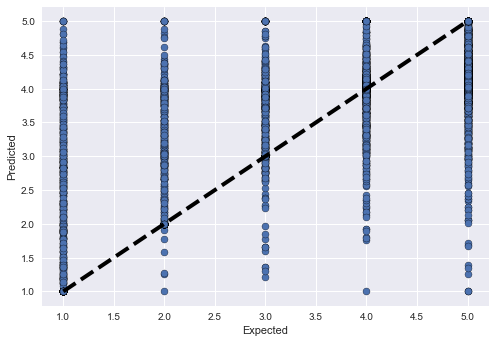

In [76]:
fig, ax = plt.subplots()
y = expected.values
ax.scatter(y, prediction, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Expected')
ax.set_ylabel('Predicted')
plt.show()

## Comparison
For burger in Las Vegas, our model beats the collaborative filtering model.
But there are only 500 restaurants and we sampled 5000 reviews, prone to overfitting. Result is expected to improve when applied to large sample.

## Improvements
3 possible variables that affect the result:

1. perplexity of the corpus of text reviews toward a single restaruant
2. number of topics (k) selected
3. number of iterations taken during SLSQP minimization


In [77]:
#lda = getlda(rest_review)

In [ ]:
import pickle
with open('lda.pickle', 'wb') as handle:
    pickle.dump(lda, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
groupby_user = rest_review.groupby('user_id').size().reset_index(name='counts')

In [ ]:
prefer_added = add_prefer_to_df(rest_review, lda, groupby_user)
prefer_added.to_csv()

In [ ]:
subscore_added = add_subscore_to_df(prefer_added, lda, group)
subscore_added.to_csv()

## Future
Evaluating the performance.

Come up with a method that does not set the topics as a whole but one for each user. However, we are struggling to see how to match topics between user and restaurant without manual labelling.